In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_data_dir = '/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training'
train_data_dir

'/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training'

In [ ]:
test_data_dir = '/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing'
test_data_dir

'/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing'

In [ ]:
batch_size = 10
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset='training',
    seed=123
)

Found 2880 files belonging to 4 classes.
Using 2304 files for training.


In [ ]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 2880 files belonging to 4 classes.
Using 576 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    seed=123
)

Found 394 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

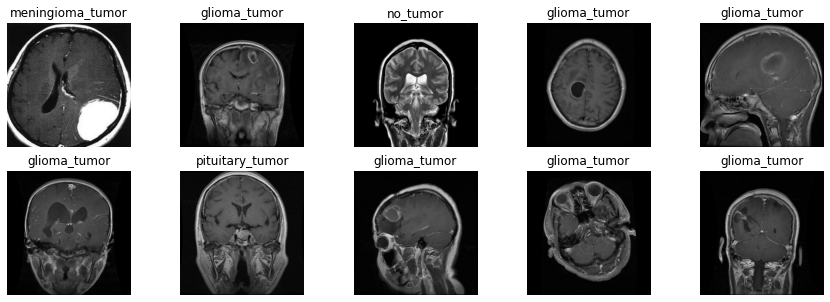

In [ ]:
plt.figure(figsize=(15,5))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) # bcz image was in tensor float32 ,turn into numpy array int8
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 256, 256, 3)
(10,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are not scaled
print(np.min(first_image), np.max(first_image))

0.0 227.38606


In [ ]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
      
  ]
)

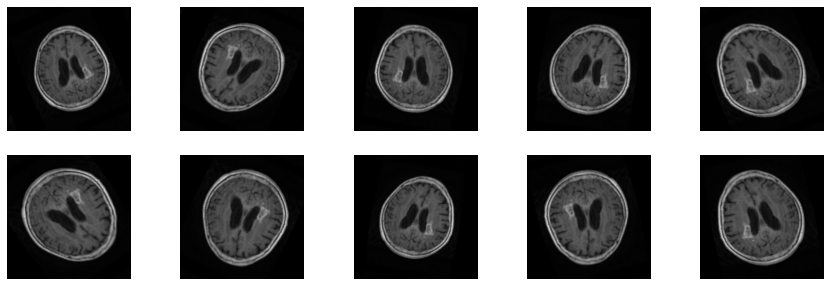

In [ ]:
plt.figure(figsize=(15,5))
for images, _ in train_ds.take(1):
  for i in range(10):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, 
                                          input_shape=(256,256,3),
                                          weights='imagenet')

In [ ]:
xception_base_model = keras.applications.xception.Xception(include_top=False,
                                                          input_shape=(256,256,3),
                                                          weights='imagenet')

In [ ]:
num_classes = len(class_names)

xception_base_model.trainable = True

base_model.trainable = False

In [ ]:
model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    xception_base_model,
    
    keras.layers.Flatten(),  # Flatten the output to feed to Dense layer
    
    keras.layers.Dense(50, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 50)                6553650   
                                                                 
 batch_normalization_4 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('Brain_X_tumor_model.h5',
                                                save_best_only=True )

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 restore_best_weights=True)

In [ ]:
keras.backend.clear_session() 

In [ ]:
from tensorflow import keras
import tensorflow as tf 
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,
                          epochs=6,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          validation_steps= validation_generator.samples// batch_size,verbose=1)

Epoch 1/6
90/90 [==============================] - 111s 1s/step - loss: 0.5699 - accuracy: 0.7559 - val_loss: 0.4667 - val_accuracy: 0.8083
Epoch 2/6
90/90 [==============================] - 107s 1s/step - loss: 0.4633 - accuracy: 0.7997 - val_loss: 0.3779 - val_accuracy: 0.8351
Epoch 3/6
90/90 [==============================] - 106s 1s/step - loss: 0.4522 - accuracy: 0.8188 - val_loss: 0.3829 - val_accuracy: 0.8469
Epoch 4/6
90/90 [==============================] - 106s 1s/step - loss: 0.3965 - accuracy: 0.8410 - val_loss: 0.3597 - val_accuracy: 0.8667
Epoch 5/6
90/90 [==============================] - 106s 1s/step - loss: 0.3509 - accuracy: 0.8590 - val_loss: 0.3008 - val_accuracy: 0.8826
Epoch 6/6
90/90 [==============================] - 111s 1s/step - loss: 0.3347 - accuracy: 0.8719 - val_loss: 0.2593 - val_accuracy: 0.8962


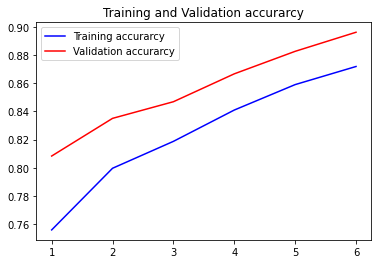

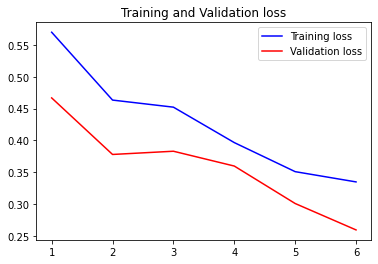

In [ ]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
xception_base_model.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, weight_decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.evaluate(test_ds)

40/40 [==============================] - 139s 3s/step - loss: 1.6468 - accuracy: 0.4086


[1.6467775106430054, 0.408629447221756]

In [ ]:
from keras.models import load_model
model.save('CRT_ADV.h5')

In [ ]:
from tensorflow.keras.models import load_model
model1=load_model('/content/drive/MyDrive/CRTML_ADV.h5')

Classes = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

1/1 [==============================] - 0s 420ms/step
meningioma_tumor


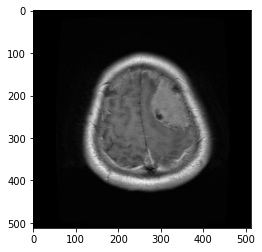

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=256
img_height=256
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from tensorflow.keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model1.predict([prepare('/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor/m (153).jpg')])
disease=image.load_img('/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor/m (153).jpg')
plt.imshow(disease)
print(Classes[np.argmax(result)])